<a href="https://colab.research.google.com/github/pstanisl/mlprague-2021/blob/main/01-movielens_epsilon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movielens - Epsilon

In [1]:
from tqdm.notebook import trange
from typing import Dict, List, Text, Tuple
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import zipfile

# Apply the default theme
sns.set_theme()

Download MovieLens 100k dataset

In [2]:
print("Downloading movielens data...")
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info').decode())

Done. Dataset contains:
943 users
1682 items
100000 ratings



## Utils

In [3]:
import csv

MOVIELENS_NUM_USERS = 943
MOVIELENS_NUM_MOVIES = 1682

def load_movielens_data(data_file):
  """Loads the movielens data and returns the ratings matrix."""
  ratings_matrix = np.zeros([MOVIELENS_NUM_USERS, MOVIELENS_NUM_MOVIES])
  with open(data_file, 'r') as infile:
    # The file is a csv with rows containing:
    # user id | item id | rating | timestamp
    reader = csv.reader(infile, delimiter='\t')
    for row in reader:
      user_id, item_id, rating, _ = row
      ratings_matrix[int(user_id) - 1, int(item_id) - 1] = float(rating)
  return ratings_matrix

## Environment

In [4]:
class MovielensEnvironment(object):
  def __init__(
      self, 
      data_dir: Text,
      rank_k: int, 
      batch_size: int = 1,
      num_movies: int = 20
  ):
    """Initializes the MovieLens Bandit environment.
    Args:
      data_dir: (string) Directory where the data lies (in text form).
      rank_k : (int) Which rank to use in the matrix factorization.
      batch_size: (int) Number of observations generated per call.
      num_movies: (int) Only the first `num_movies` movies will be used by the
        environment. The rest is cut out from the data.
    """
    self._num_actions = num_movies
    self._batch_size = batch_size
    self._context_dim = rank_k

    # Compute the matrix factorization.
    self._data_matrix = load_movielens_data(data_dir)
    # Keep only the first items.
    self._data_matrix = self._data_matrix[:, :num_movies]
    # Filter the users with no iterm rated.
    nonzero_users = list(np.nonzero(np.sum(self._data_matrix, axis=1) > 0.0)[0])
    self._data_matrix = self._data_matrix[nonzero_users, :]
    self._effective_num_users = len(nonzero_users)

    # Compute the SVD.
    u, s, vh = np.linalg.svd(self._data_matrix, full_matrices=False)
    # Keep only the largest singular values.
    self._u_hat = u[:, :rank_k] * np.sqrt(s[:rank_k])
    self._v_hat = np.transpose(
        np.transpose(vh[:rank_k, :]) * np.sqrt(s[:rank_k]))
    self._approx_ratings_matrix = np.matmul(self._u_hat, self._v_hat)

    self._current_users = np.zeros(batch_size)
    self._previous_users = np.zeros(batch_size)

    self._optimal_action_table = np.argmax(
        self._approx_ratings_matrix, axis=1)
    self._optimal_reward_table = np.max(
        self._approx_ratings_matrix, axis=1)
    
    #self._params = params
    #self._observe()
    self.reset()

  @property
  def batch_size(self):
    return self._batch_size

  @property
  def best_arm(self) -> int:
    return np.argmax(np.sum(env._data_matrix, axis=0))

  @property
  def n_arms(self) -> int:
    return self._data_matrix.shape[1]

  def reset(self):
    return self._observe()

  def _observe(self) -> np.ndarray:
    """Returns the u vectors of a random sample of users."""
    sampled_users = random.sample(
        range(self._effective_num_users), self._batch_size)
    self._previous_users = self._current_users
    self._current_users = sampled_users
    batched_observations = self._u_hat[sampled_users]
    return batched_observations

  def step(self, action: List[int]) -> Tuple[int, float]:
    """Computes the reward for the input actions."""
    rewards = []
    for i, j in zip(self._current_users, action):
      rewards.append(self._approx_ratings_matrix[i, j])
    return np.array(rewards)
  
  def best_action(self):
    return np.argmax(self._params)

In [5]:
env = MovielensEnvironment('./ml-100k/u.data', rank_k=20, batch_size=1, num_movies=20)
env.step([4])

array([4.])

In [6]:
env.best_arm

0

## Policy

In [7]:
class EpsilonGreedyPolicy(object):
  def __init__(self, epsilon: float, values: List[float], batch_size: int = 1):
    self._epsilon = epsilon
    self._values = values

    self._batch_size = batch_size

  def action(self) -> int:
    val_max = max(self._values)

    ret = []

    for rnd in np.random.rand(self._batch_size):
      if rnd > self._epsilon:
        ret.append(np.random.choice(
            [i for i, val in enumerate(self._values) if val == val_max]))
      else:
        ret.append(np.random.randint(len(self._values)))
    
    return ret

In [8]:
pol = EpsilonGreedyPolicy(epsilon=0.1, values=[1, 2, 3], batch_size=10)
action = pol.action()
print(f'{action}')

[2, 2, 2, 1, 2, 2, 2, 2, 2, 2]


## Agent

In [9]:
class EpsilonGreedyAgent(object):
  
  def __init__(self, n: int, epsilon: float = 0.1, batch_size: int = 1):
    self._epsilon = epsilon
    self._n = n
    self._batch_size = batch_size

    self.reset()

    self.policy = EpsilonGreedyPolicy(
        self._epsilon, self._values, batch_size=batch_size)

  def reset(self):
    self._counts = [0] * self._n
    self._values = [0.0] * self._n

  def train(self, experience: Dict[str, float]):
    action = experience['action']
    reward = experience['reward']

    self._counts[action] += 1

    value = self._values[action]
    n = self._counts[action]

    self._values[action] = ((n - 1) / n) * value + (1 / n) * reward

In [10]:
ag = EpsilonGreedyAgent(3)

experience = {'action': 2, 'reward': 1}
ag.train(experience)
print(f'values={ag._values}')

experience = {'action': 2, 'reward': 0}
ag.train(experience)
print(f'values={ag._values}')

values=[0.0, 0.0, 1.0]
values=[0.0, 0.0, 0.5]


## Utils

In [11]:
def create_accuracies(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy() 
  df['price'] = 1
  df = pd.pivot_table(df, index='trial', columns=['action'], aggfunc=np.sum).price
  df['sum'] = df.sum(axis=1)
  df = df.loc[:,:].div(df["sum"], axis=0)
  df.columns = [f'action_{action}' for action in df.columns]

  return df.reset_index().fillna(0)


def plot_accuracy(df: pd.DataFrame, best_action):
  plt.figure(figsize=(10, 7))
  
  #if hyperparameter:
  #  for parameter in df[hyperparameter].unique():
  #    plt.plot(
  #        df[df[hyperparameter] == parameter]['trial'],
  #        df[df[hyperparameter] == parameter][f'arm_{best_arm}'],
  #        label=parameter
  #    )
  #    plt.legend(title=hyperparameter)
  #else:
  #  plt.plot(df.trial, df[f'arm_{best_arm}']) 
  for epsilon in df.epsilon.unique():
    df_acc = create_accuracies(df[df.epsilon == epsilon])
    
    plt.plot(
        df_acc.trial, 
        df_acc[f'action_{best_action}'], 
        label=f'action={best_action} (epsilon={epsilon})'
    )

  plt.xlim(0)
  plt.ylim(0, 1)
  plt.xlabel('Number of trials')
  plt.ylabel('Probability of Selecting Best Arm')
  plt.legend()
  #plt.title(f'Accuracy of the {algorithm_name} Algorithm')
  plt.show()


def plot_actions(df: pd.DataFrame):
  #probabilities = sorted(range(env.n_arms), key=lambda k: env.params[k][0], reverse=True)
  df_acc = create_accuracies(df)

  plt.figure(figsize=(10, 7))

  for action in df.action.unique():
      plt.plot(
          df_acc.trial,
          df_acc[f'action_{action}'],
          label=f'action={action}'
      )
  #plt.legend(title='Sorted Actions')

  plt.xlim(0)
  plt.xlabel('Number of Trials')
  plt.ylabel('Probability of Selecting Each Action')
  # plt.title('Arm Selection Rate of the {} Algorithm'.format(algorithm_name))
  plt.show()


def plot_cumsum(df: pd.DataFrame, show_actions=False):
  plt.figure(figsize=(10, 7))

  df = df.copy()

  if show_actions:
    df_actions = df.groupby(['trial', 'action']).mean().reset_index()

    for action in sorted(df.action.unique()):
      plt.plot(
          df_actions[df_actions['action']==action].trial, 
          df_actions[df_actions['action']==action].action_cum_sum,
          label=f'action={int(action)} cumulative reward'
      )

  df_all = df.groupby('trial')['cum_sum'].mean().reset_index()

  plt.plot(
    df_all.trial, 
    df_all.cum_sum, 
    linestyle='--', 
    label='avg. agent cumulative reward'
  )

  plt.xlim(0)
  plt.xlabel('Number of trials')
  plt.ylabel('Cumulative Reward')
  plt.legend()
  #plt.title(f'Cumulative Reward of the {algorithm_name} Algorithm')
  plt.show()

## Experiment

In [12]:
def run(environment: object, agent: object, trials=100):
  trajectory = []

  experience = {'trial': 0, 'action': -1, 'observation': 0, 'reward': 0}

  for i in range(trials):
    experience['trial'] = i + 1
    actions = agent.policy.action()
    rewards = environment.step(actions)

    for action, reward in zip(actions, rewards):
      experience['action'] = action
      experience['reward'] = reward
      agent.train(experience)

      #df_trajectory = df_trajectory.append(experience, ignore_index=True)
      trajectory.append(experience.copy())
    
  df_trajectory = pd.DataFrame.from_dict(trajectory)
  df_cumsum = df_trajectory.groupby('action')['reward'].cumsum()
  df_trajectory = df_trajectory.assign(cum_sum=df_trajectory['reward'].cumsum())
  df_trajectory = df_trajectory.assign(action_cum_sum=df_cumsum)

  return df_trajectory.astype({'action': 'int32', 'trial': 'int32'})

In [13]:
environment = MovielensEnvironment('./ml-100k/u.data', rank_k=20, batch_size=1, num_movies=20)
step = environment.reset()

agent = EpsilonGreedyAgent(
    environment.n_arms, epsilon=0.1, batch_size=environment.batch_size)
experience = {'action': [-1], 'reward': [0]}

df_trajectory = run(environment, agent, trials=2500)

print(f'\nvalues={agent._values}')
print(f'best action={np.argmax(agent._values)}')


values=[6.376674130694006e-15, -2.932905286430544e-15, 1.7113862574170397e-16, -3.8338741123371465e-15, -9.273612053581006e-16, 3.587075697347185e-16, 1.9999999999999991, -3.4120359712195187e-15, 4.000000000000005, 3.2672636138643226e-16, -7.810863202258096e-15, -7.92898756749851e-15, 2.6867387250834642e-17, 5.524052697876363e-15, 7.783397601005436e-15, 1.2430124214583183e-15, -2.7675796400202066e-15, -4.635688323413015e-16, 2.8112649325681e-15, 2.2615417488684764e-16]
best action=8


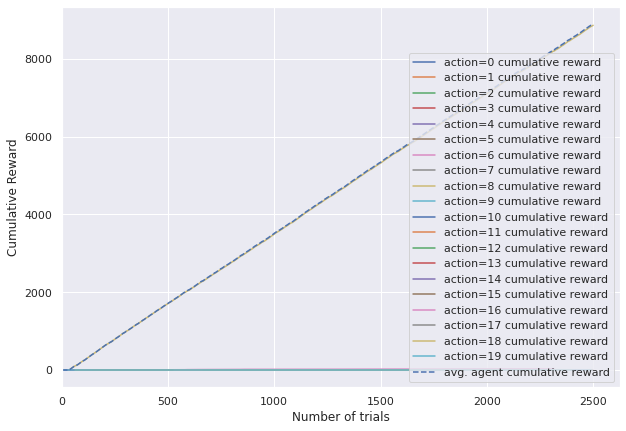

In [14]:
plot_cumsum(df_trajectory.copy(), show_actions=True)

### Epochs

In [15]:
def experiment(epsilons: List[float], epochs: int = 1, trials: int = 10, batch_size: int = 1):
  trajectories = []
  
  environment = MovielensEnvironment(
      './ml-100k/u.data', rank_k=20, batch_size=batch_size, num_movies=20)
  params = {'best_action': environment.best_arm}
  
  for epsilon in epsilons:
    for epoch in trange(epochs):
      step = environment.reset()
      agent = EpsilonGreedyAgent(
          environment.n_arms, epsilon=0.1, batch_size=environment.batch_size)
      
      df = run(environment, agent, trials=trials)
      df['epoch'] = epoch + 1
      df['epsilon'] = epsilon
      #df['best action'] = np.argmax(agent._values)

      #print(df)

      trajectories.append(df)

  df_trajectory = pd.concat(trajectories, ignore_index=True)

  return df_trajectory.astype({'action': 'int32', 'trial': 'int32'}), params

In [16]:
df_trajectory, params = experiment(epsilons=[0.1], epochs=250, trials=500, batch_size=200)

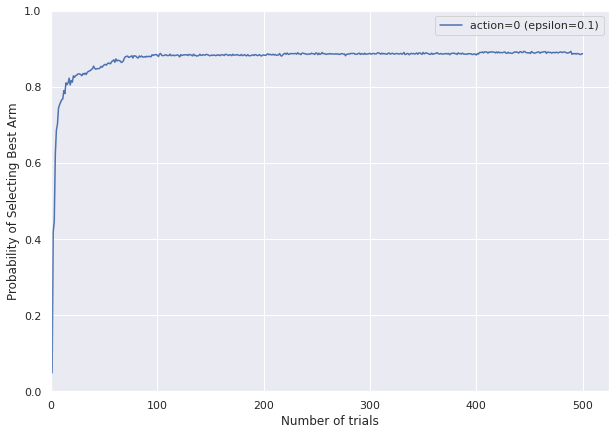

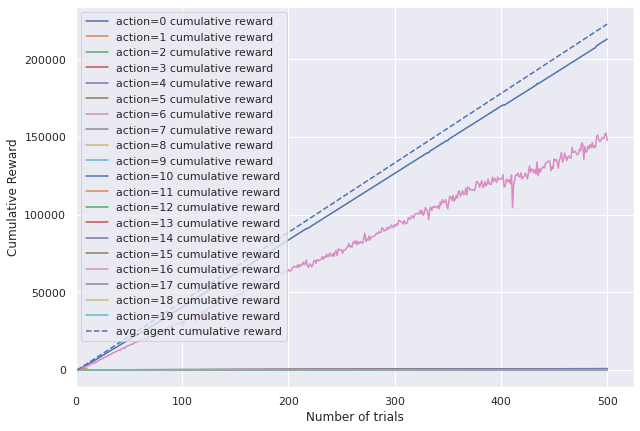

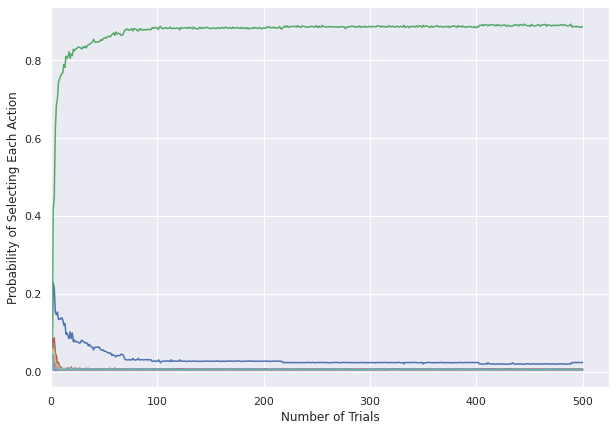

In [17]:
plot_accuracy(df_trajectory, params['best_action'])
plot_cumsum(df_trajectory[df_trajectory.epsilon == 0.1], show_actions=True)
plot_actions(df_trajectory[df_trajectory.epsilon == 0.1])